# Interpreting ResNet CIFAR-10 Training Process With Training Dynamics

This notebook trains a ResNet model using noisy CIFAR-10 dataset and employed Beyond Hand-Designed Feature(BHDF) algorithm, specifically `BHDFInterpreter`, to investigate and record the training dynamics. By establishing representation learning form training dynamics, BHDF proposes a dataset-transferable noise detector to identify the label noises in target datasets

In [1]:
import paddle
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import interpretdl as it
!ln -s ../tutorials/assets assets

ln: failed to create symbolic link ‘assets/assets’: File exists


/home/work/miniconda3/envs/pptest/lib/python3.9/site-packages/interpretdl/data_processor/visualizer.py:4: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML
/home/work/miniconda3/envs/pptest/lib/python3.9/site-packages/sklearn/utils/multiclass.py:14: DeprecationWarning: Please use `spmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.base` namespace is deprecated.
  from scipy.sparse.base import spmatrix
/home/work/miniconda3/envs/pptest/lib/python3.9/site-packages/sklearn/utils/optimize.py:18: DeprecationWarning: Please use `line_search_wolfe2` from the `scipy.optimize` namespace, the `scipy.optimize.linesearch` namespace is deprecated.
  from scipy.optimize.linesearch import line_search_wolfe2, line_search_wolfe1
/home/work/miniconda3/envs/pptest/lib/python3.9/site-packages/sklearn/utils/optimize.py:18: DeprecationWarning: Please use `line_searc

Define the training dataset using the CIFAR10 dataset generator from **paddle.vision.datasets**.

In [2]:
from paddle.vision.transforms import Transpose
from paddle.vision.datasets import Cifar10

class dataset(paddle.io.Dataset):
    """
    Modify output of getitem.
    
    :param :`paddle.io.Dataset`: base_dataset: Dataset to wrap

    """
    def __init__(self,
                 base_dataset: object,
                 assigned_labels=None):
        super().__init__()
        self.dataset = base_dataset
        self.assigned_labels = assigned_labels

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        input, target = self.dataset[index]
        if self.assigned_labels is not None:
            target = self.assigned_labels[index]
        return index, (input/255.0).astype(np.float32), int(target)

cifar10 = dataset(Cifar10(mode='train', transform=Transpose()))
labels = [cifar10.__getitem__(i)[2] for i in range(cifar10.__len__())]

We use CIFAR10 for a quick replication. Also, we inject some hand-craft label noises in this demo to make the detection result more salient.

In [3]:
# inject 10% "sym" noise
import random
nr = 0.1
noise_labels = []
idx = list(range(50000))
random.shuffle(idx)
num_noise = int(nr*50000)            
noise_idx = idx[:num_noise]
for i in range(50000):
    if i in noise_idx:
        noiselabel = random.randint(0,9) 
        noise_labels.append(noiselabel)
    else:    
        noise_labels.append(labels[i]) 
        
noisy_cifar10 = dataset(Cifar10(mode='train', transform=Transpose()),assigned_labels=noise_labels)

Initialize the ResNet18 model using **paddle.vision.models**.

In [4]:
from paddle.vision.models import resnet18
model = resnet18(pretrained=False, num_classes=10)

W0426 00:46:41.974071 64620 gpu_resources.cc:61] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.4, Runtime API Version: 10.2
W0426 00:46:41.979385 64620 gpu_resources.cc:91] device: 0, cuDNN Version: 7.6.


Set up a data loader with batch size of 128, and an Momentum optimizer for training.

**Note:** the data generator shoud be able to generate the index of each sample, the sample and its label, so that each sample's behavior can be recorded according to its index.

In [5]:
train_loader = paddle.io.DataLoader(noisy_cifar10, batch_size=128, shuffle=True,num_workers=4)
scheduler = paddle.optimizer.lr.MultiStepDecay(learning_rate=0.1, milestones=[50,],gamma=0.1)
optimizer = paddle.optimizer.Momentum(learning_rate=scheduler, parameters=model.parameters(),weight_decay=1e-4,momentum=0.9,use_nesterov=True)

First initialize the `TrainingDynamicsInterpreter` and then start `generator`ing the training process by training 200 epochs. 

*training_dynamics* is a dictionary that maps image index to each epoch's predictions in the training process; assigned_targets is list indicating the assigned targets (maybe noisy) for each sample. They are saved at "assets/training_dynamics.npz" as default.

In [6]:
TDI = it.TrainingDynamics(model, device='gpu:0')

epochs = 30
print('Training %d epochs. This may take some time.' % epochs)
training_dynamics = TDI.generator(
    train_loader=train_loader,
    optimizer=optimizer,
    epochs=epochs
)

Training 30 epochs. This may take some time.


/home/work/miniconda3/envs/pptest/lib/python3.9/site-packages/paddle/nn/layer/norm.py:653: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


| Epoch [ 30/ 30] Iter[391]		Loss: 0.3632 Acc@1: 93.286%%

In [7]:
lf = (np.array(noise_labels)!=np.array(labels)).astype(int)

In [8]:
TDI.save(training_dynamics,assigned_targets=noise_labels,label_flip=lf,save_path='assets')

Save: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:01<00:00, 33499.72it/s]


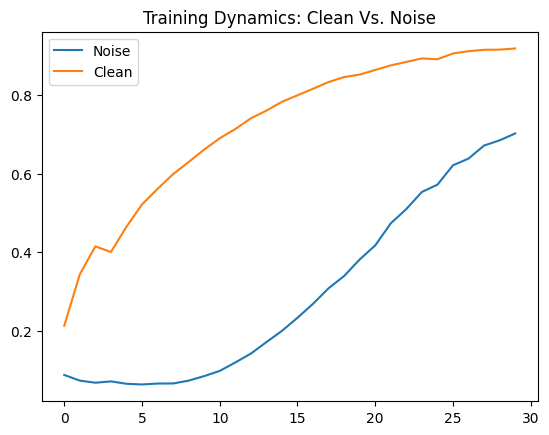

In [10]:
n_set = np.where(lf==True)[0]
c_set = np.where(lf==False)[0]

td = np.load('assets/training_dynamics.npz')['td'][:,:,0]
import matplotlib.pyplot as plt
plt.figure()
plt.plot(td[n_set].mean(axis=0))
plt.plot(td[c_set].mean(axis=0))
plt.title('Training Dynamics: Clean Vs. Noise')
plt.legend(labels=['Noise','Clean'])
plt.show()

# predict and rank

With help of representation learning from time-series data, a two-layer LSTM model can be instanced as a noise detector to identify the underlying label noise in CIFAR-10 dataset  

In [11]:
BHDF = it.BHDFInterpreter(device='gpu:0')
order,predictions = BHDF.interpret(training_dynamics_path="assets/training_dynamics.npz")

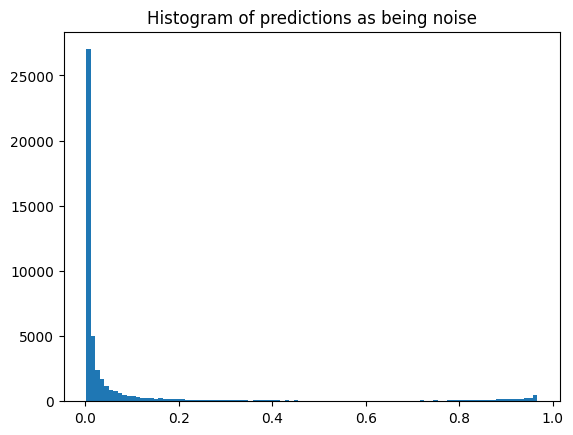

In [12]:
import matplotlib.pyplot as plt
plt.hist(predictions,bins=100)
plt.title('Histogram of predictions as being noise')
plt.show()

# visulization

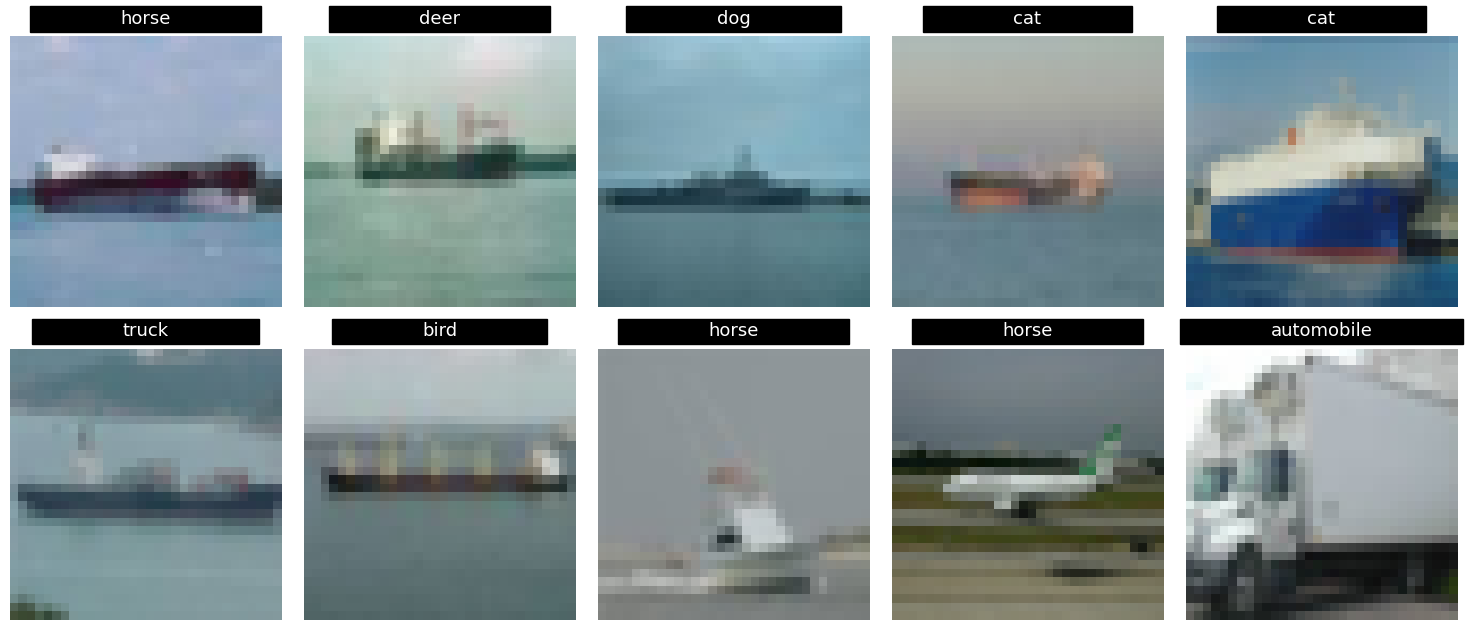

In [13]:
def showsomesamples(train_dataset,indices,names):
    
    index = indices[i]
    image = train_dataset.__getitem__(index)[1].transpose(1,2,0)
    label = train_dataset.__getitem__(index)[2]

    ax=fig.add_subplot(rows, columns, i+1)
    ax.spines['left'].set_color('r')
    ax.spines['right'].set_color('r')
    ax.spines['top'].set_color('r')
    ax.spines['bottom'].set_color('r')

    plt.imshow(image)
    plt.axis('off')

    title = ax.set_title(names[label], fontsize=13,position=(.5, 1),
             backgroundcolor='black', color='white',
             verticalalignment="bottom", horizontalalignment="center")
    title._bbox_patch._mutation_aspect = 0.04
    title.get_bbox_patch().set_boxstyle("square", pad=5)
    plt.tight_layout()
    
#top 10
rows = 2
columns = 5
labeldict={0:'airplane',
           1:'automobile',
           2:'bird',
           3:'cat',
           4:'deer',
           5:'dog',
           6:'frog',
           7:'horse',
           8:'ship',
           9:'truck'}

fig = plt.figure(figsize=(3*columns, 3.2*rows))
for i in range(rows*columns):
    showsomesamples(noisy_cifar10,np.flip(order[-rows*columns:]),labeldict)